# ECG Heartbeat Classification EDA
### Background information
- **Electrocardiogram(ECG)** measures the hearts electrical activity of the heart.
- According to (Kachuee et al., 2018), Manual ECG review are difficult when detecting and categorizing different waveforms and morphologies

#### How does a heartbeat look like in a ECG signal?

To answer that, we must understand the different parts of the wave:
* __P-wave__: Starts the heartbeat, the atria(upper chamber) is contracting
* __PR interval__: Repersents the time it takes for the electical move between the __atria and the ventricle__. This time repersents the heart __natural pacemaker__.
* __QRS Complex__: Basically the beat, the sharp spike, this is when the __ventricle__ contracts and pushes blood through the body
* __ST segment__: The heart is basically relaxing here before the next heartbeat
* __T wave__: The final wave -- repolarization of the ventricles, preparing for the next heart beat

These shapes are what the machine learning model will learn to predict what is __normal__ vs __abnormal__.

### Figure 1
![ECG Heartbeat](./images/heatbeat.png)

### Objective -- what are we trying to look for?
- We want the machine learning model to know the  __statistical and morphological differences__, such that it can __reliably detects anomalies__ within the waves, and those anomolies can be classified.

### Imports

In [15]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import find_peaks
from scipy.stats import kurtosis, skew, zscore

### Constants

In [16]:
FS = 125
LABEL_COL = 187
CLASSES = {0: "N", 1: "S", 2: "V", 3: "F", 4: "Q"}
RANDOM_SEED = 42
CLASSIFICATION_COL = 186

## EDA
- both mitbih and ptbdb contain enough data to train a deep learning model.
- I believe the ptbdb contains categories that contains heart attacks -- myocardial infractions
- Also, the last column should indicate what the heart beat is classified as

### Dataset Summary

In [28]:
# Paths to data ECG_Classification/.data/mitbih_train.csv
normal_train_path = "./.data/ptbdb_normal.csv"
abnormal_train_path = "./.data/ptbdb_abnormal.csv"
normal_df = pd.read_csv(normal_train_path, header=None)
abnormal_df = pd.read_csv(abnormal_train_path, header=None)

In [29]:
normal_df.shape, abnormal_df.shape

((4046, 188), (10506, 188))

In [30]:
normal_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
classes_freq = normal_df.iloc[:, -1].value_counts()
sorted_classes_freq = classes_freq.sort_index()
sorted_classes_freq

187
0.0    4046
Name: count, dtype: int64

In [32]:
classes_freq = abnormal_df.iloc[:, -1].value_counts()
sorted_classes_freq = classes_freq.sort_index()
sorted_classes_freq

187
1.0    10506
Name: count, dtype: int64

__Arrhythmia Dataset__
* __Total Samples__: 4045(Normal Samples) + 10505(Abnormal Samples) = 14550 Samples/Rows
* __Classes__: Abnormal(1) and Normal(0)

### General Data Cleaning
- Checking for missing values.
- No need to check for duplicate values for columns because signals is periodic wave, therefore, their should be duplicates.
- I am going to stick with float 32 percision because that is sufficent enough.


In [51]:
assert normal_df.isna().sum().sum() == 0
print("No missing values in normal data!")

No missing values in normal data!


In [53]:
assert abnormal_df.isna().sum().sum() == 0
print("No missing value in abnormal data!")

No missing value in abnormal data!


In [44]:
print("Normal Data Column Types:")
normal_df.dtypes

Normal Data Column Types:


0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
183    float64
184    float64
185    float64
186    float64
187    float64
Length: 188, dtype: object

In [45]:
print("Abnormal Data Column Types:")
abnormal_df.dtypes

Abnormal Data Column Types:


0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
183    float64
184    float64
185    float64
186    float64
187    float64
Length: 188, dtype: object

In [46]:
# Since all the columns are numerical, we will change them all into float32
normal_df = normal_df.astype("float32")
normal_df.dtypes

0      float32
1      float32
2      float32
3      float32
4      float32
        ...   
183    float32
184    float32
185    float32
186    float32
187    float32
Length: 188, dtype: object

In [47]:
abnormal_df = abnormal_df.astype("float32")
abnormal_df.dtypes

0      float32
1      float32
2      float32
3      float32
4      float32
        ...   
183    float32
184    float32
185    float32
186    float32
187    float32
Length: 188, dtype: object

### Question I Want to Answer To:
- Are their outliers within groups? -- use of z-scores


Before we statically find outliers or see if the groups are statistically different. Let us first see it __visually__ by __selecting two random ECG signal from each dataset(i.e., Normal and Abnormal)__. We choose at random, two from the same dataset to see if we can see variation visually. Then we are getting for each dataset to see if they look different from each other. The code below does the following.

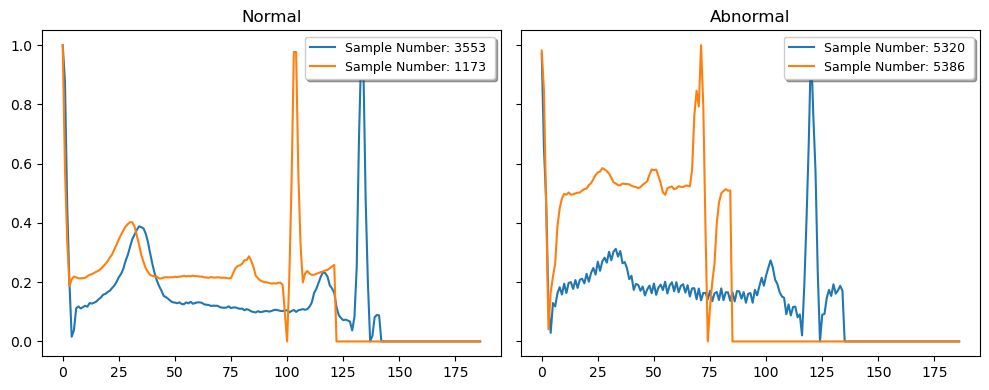

In [38]:
def visualize_differences_with_line_graph(
    normal: pd.DataFrame, abnormal: pd.DataFrame
) -> None:
    """Visualize differences within group and between groups.

    The signals are chosen at random.

    Args:
      normal : pd.DataFrame
        Dataframe that contains the normal ECG signal of a heart.
      abnormal : pd.DataFrame
        Dataframe that contains the abnormal ECG signal of a heart.

    Returns:
     Two plots, one for abnormal and the other for normal. Each
     containing two signals.
    """
    two_rand_numbers = 2
    # Tell us which signal we are choosing
    first_within_signal = 0
    second_within_signal = 1
    first_between_signal = 0
    second_betwee_signal = 1

    # Randomly chooses a signal
    choose_rand_normal_signal = np.random.randint(0, len(normal_df), two_rand_numbers)
    choose_rand_abnormal_signal = np.random.randint(
        0, len(abnormal_df), two_rand_numbers
    )
    # Plotting
    first_plot = 1
    second_plot = 2
    fig, axes = plt.subplots(first_plot, second_plot, sharey=True, figsize=(10, 4))

    # Normal signal plotting
    axes[first_between_signal].plot(
        normal_df.iloc[choose_rand_normal_signal[first_within_signal], :-1].values,
        label=f"Sample Number: {choose_rand_normal_signal[first_within_signal]} ",
    )
    # Second normal signal
    axes[first_between_signal].plot(
        normal_df.iloc[choose_rand_normal_signal[second_within_signal], :-1].values,
        label=f"Sample Number: {choose_rand_normal_signal[second_within_signal]} ",
    )
    axes[first_between_signal].legend(
        shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9
    )
    axes[first_between_signal].set_title("Normal")

    # Abnormal Signal plotting
    axes[second_betwee_signal].plot(
        abnormal_df.iloc[choose_rand_abnormal_signal[first_within_signal], :-1].values,
        label=f"Sample Number: {choose_rand_abnormal_signal[first_within_signal]} ",
    )
    # Second abnormal signal
    axes[second_betwee_signal].plot(
        abnormal_df.iloc[choose_rand_abnormal_signal[second_within_signal], :-1].values,
        label=f"Sample Number: {choose_rand_abnormal_signal[second_within_signal]} ",
    )
    axes[second_betwee_signal].legend(
        shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9
    )
    axes[second_betwee_signal].set_title("Abnormal")
    plt.tight_layout()
    plt.show()


visualize_differences_with_line_graph(abnormal=abnormal_df, normal=normal_df)

### Line Graph Plotting analysis conclusions
- From plotting the signals, it seems that they grab a signal by capturing ~1.5s after the first __R wave__. Hence why you can see a small bump(i.e.__T wave__), then as we near the second __R wave__ we can see a smaller __P Wave__. 

Based on that conclusion, we can visualize those region of the heart beat more accuratly if we generate box plots for the time points that contain __T wave__. Naively, I am going to choose time point 25, 50, as those indicate the __T wave__ presence. Additionally, I can see there seems to be some __variation/differences__ within the

def visualize_informative_regions()

### Statically Checks:
- do the normal or abnormal have data that are considered outliers?

To check if there are __outlier__ within the normal or abnormal dataset. We will preform __Focused Z-score outlier detection__. What that means is that we are trying to find heart beats signals that differ within their own category(i.e., normal and abnormal).

In [35]:
# Removing the classifications from the abnormal and normal dfs.
normal_X = normal_df.iloc[:, :-1].values
normal_y = normal_df[LABEL_COL]
abnormal_X = ab

# The threshold is used to see how many times is a value
# greater or less than the average. generally, 3 times
# is considered the sweet spot, however, signal have
# alot of variation because it can be inflenced by alot
# of things. so 6 times might be the best choice in
# this situation.
threshold = 6
normal_unclassified_df = normal_df.iloc[:, :-1].values
# axis = 1 means that we are doing it column by colums
z_scores = np.abs(zscore(normal_unclassified_df, axis=1))
# This finds the rows where the z-score is
outlier_rows = np.where(np.max(z_scores, axis=1) > threshold)[0]